<a href="https://colab.research.google.com/github/catmasteryip/Deep-Learning/blob/master/CIFAR10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import libraries

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='sample_data',train=True,download=True,transform=transform)

Extracting sample_data/cifar-10-python.tar.gz to sample_data


In [5]:
test_data = datasets.CIFAR10(root='sample_data',train=False,download=True,transform=transform)

Files already downloaded and verified


In [6]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: sample_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [0]:
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [0]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

In [0]:
for images, labels in train_loader:
  break

In [12]:
labels

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

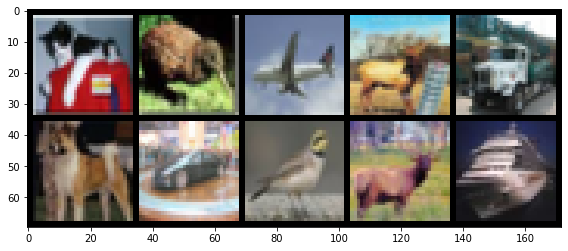

In [14]:
im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

Define Model

In [0]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5,1) #(1,6,5,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    #(((32-2)/2)-2)/2 = 6.5 = 6 px per side
    #convolution, pooling, convolution, pooling
    self.fc1 = nn.Linear(6*6*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X,2,2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X,2,2)
    #flatten the image into a 6*6*16 vector
    X = X.view(-1,6*6*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [17]:
torch.manual_seed(101)
model = CNN()
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

No of parameters

In [20]:
sum_of_param = 0
for param in model.parameters():
  sum_of_param += param.numel()
print(sum_of_param)

81590


Set criterion and optimizer

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

Training and tracking losses

In [22]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.64397550  accuracy:  27.220%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.34126639  accuracy:  33.120%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.90066683  accuracy:  36.640%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.60579610  accuracy:  39.023%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 2.21494412  accuracy:  40.840%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.26989377  accuracy:  50.050%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.71420288  accuracy:  50.525%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 0.83952016  accuracy:  50.800%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.12069774  accuracy:  51.212%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.45792830  accuracy:  51.682%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 0.92928541  accuracy:  56.040%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 1.03454006  accuracy:  56.370%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.40866721  accuracy:  56.423%
epoch:  2  b

Save model

In [0]:
torch.save(model.state_dict(),'myCIFARmodel.pt')

Plot losses

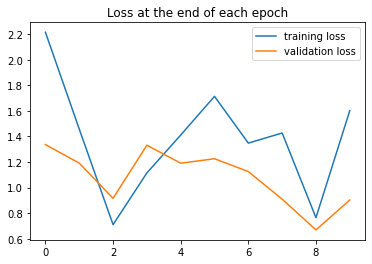

In [24]:
plt.plot(train_losses,label = 'training loss')
plt.plot(test_losses,label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

Plot accuracies

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


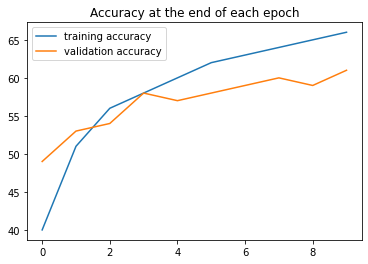

In [25]:
plt.plot([t/500 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [28]:
print(test_correct[-1].item()*100/10000)

61.01


Confusion Matrix, low recall in trucks and cars

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


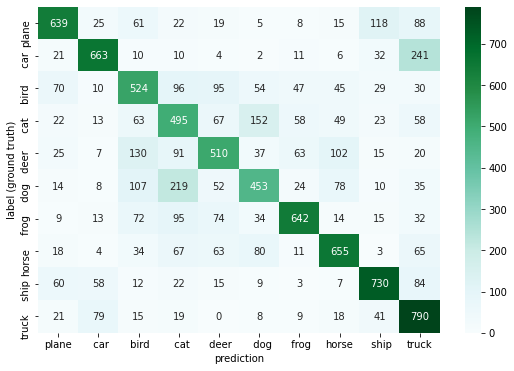

In [30]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
import seaborn as sn
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();